## Taller #8: Modelado de temas

- Importación de librerias

In [53]:
import re
import pandas as pd
import numpy as np
from pprint import pprint

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')

import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary

import re
from nltk.corpus import stopwords
from pprint import pprint

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

- Cargar datos

In [9]:
# Cargar datos

path = 'C:/Users/diego.diaz/Desktop/script seg KL/NLP/Clase9/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


In [12]:
# dimensión

data.shape

(1000, 8)

###  `[12 pts]` Punto 1: Hacer pre-procesamiento del texto

In [29]:
stopwords = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [palabra for palabra in texto.split() if palabra not in stopwords]
    return texto

In [71]:
data.loc[:,['review_body','Pre-Processed']].head()

,review_body,Pre-Processed
0,"Buen. Buena calidad, y buena presentación.","[buen, buena, calidad, buena, presentación]"
1,"Un producto a perfecto, para salir de casa con...","[producto, perfecto, salir, casa, nintendo, sw..."
2,No funciona con Nintendo Switch. No hay forma ...,"[funciona, nintendo, switch, forma, emparejarl..."
3,"Recomendado, los utilizo para pc y no me dan n...","[recomendado, utilizo, pc, dan, ningún, proble..."
4,El cable funciona bien podria ser un poco mas ...,"[cable, funciona, bien, podria, ser, mas, larg..."


###  `[13 pts]` Punto 2: Modelo de LDA

Mas información:

https://www.tutorialspoint.com/gensim/gensim_creating_lda_mallet_model.htm

In [33]:
# Crear una representación de los documentos en forma de diccionario
dictionary = Dictionary(data['Pre-Processed'].values)

# Filtrar palabras muy frecuentes o infrecuentes
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in data['Pre-Processed'].values]

#Train the topic model
model = LdaModel(corpus=corpus, random_state=2805, id2word=dictionary, num_topics=4, passes=20)

###  `[25 pts]` Punto 3: Visualización de LDA

In [34]:
pprint(model.print_topics(num_words=10))

[(0,
  '0.050*"calidad" + 0.034*"precio" + 0.032*"bien" + 0.027*"buena" + '
  '0.020*"bonito" + 0.017*"foto" + 0.016*"queda" + 0.015*"juego" + '
  '0.015*"cadena" + 0.014*"parece"'),
 (1,
  '0.016*"calidad" + 0.016*"bien" + 0.014*"cable" + 0.013*"mejor" + '
  '0.013*"mando" + 0.013*"precio" + 0.013*"si" + 0.012*"roto" + 0.012*"mal" + '
  '0.011*"bastante"'),
 (2,
  '0.028*"bonitos" + 0.027*"regalo" + 0.025*"plata" + 0.020*"día" + '
  '0.020*"llegado" + 0.016*"pendientes" + 0.015*"pequeños" + 0.015*"tamaño" + '
  '0.014*"bonito" + 0.012*"quedan"'),
 (3,
  '0.030*"bien" + 0.027*"juego" + 0.026*"si" + 0.026*"producto" + '
  '0.017*"perfecto" + 0.017*"caja" + 0.014*"tiempo" + 0.012*"jugar" + '
  '0.012*"mas" + 0.012*"llego"')]


**Métricas:**

- Perplejidad:

Nos dice que tan bueno es el modelo, cuanto menor sea la puntuación, mejor será.

In [35]:
print('\nPerplexity: ', model.log_perplexity(corpus))


Perplexity:  -6.131933156276812


- Coherencia:

Calcula la puntuación de coherencia del modelo, es decir, la media / mediana de las puntuaciones de similitud de palabras por pares de las palabras del tema.

https://palmetto.demos.dice-research.org/

In [42]:
from gensim.models.coherencemodel import CoherenceModel


coh = ['c_v','u_mass','c_uci','c_npmi']

print("Coherence Score: ")
for c in coh:
    coherence_model_lda = CoherenceModel(model=model, 
                                     corpus=corpus, 
                                     texts=data['Pre-Processed'].values, 
                                     dictionary=dictionary, 
                                     coherence=c)
    
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"\n{c}: {coherence_lda:>9.5f}")

Coherence Score: 

c_v:   0.29271

u_mass:  -6.08625

c_uci:  -4.31120

c_npmi:  -0.12369


In [43]:
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_display)

De la salida anterior, las burbujas en el lado izquierdo representan un tema y cuanto más grande es la burbuja, más frecuente es ese tema. El modelo de tema será bueno si el modelo de tema tiene burbujas grandes que no se superponen repartidas por todo el gráfico.

### Número de Tópicos óptimo

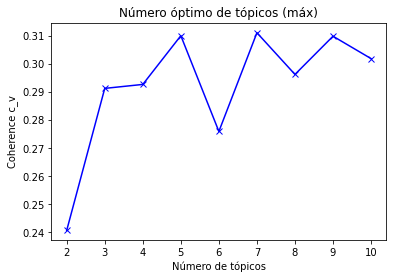

In [55]:
num_top = []
coherence_cv = []

topics = np.arange(2,11)

for t in tqdm_notebook(topics):
    
    #Train the topic model
    model = LdaModel(corpus=corpus, random_state=2805, id2word=dictionary, num_topics=t, passes=20)
    
    coherence_model_lda = CoherenceModel(model=model, 
                                     corpus=corpus, 
                                     texts=data['Pre-Processed'].values, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    
    num_top.append(t)
    coherence_cv.append(coherence_lda)

    
plt.xlabel("Número de tópicos"); 
plt.ylabel("Coherence c_v");
plt.title('Número óptimo de tópicos (máx)')
plt.plot(num_top, coherence_cv, 'bx-');

Viendo la gráfica se puede evidenciar que un número óptimo de de tópicos puede ser $t=5$.